In [44]:
%matplotlib inline 
from assignment_utils import *

In [45]:
import os
import random

from itertools import product

import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, dot, merge
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Lambda
from keras.layers import Bidirectional, Conv2D, Conv2DTranspose, LSTM, MaxPool1D
from keras.layers import Layer as KerasLayer, Reshape
from keras.layers.normalization import BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy, mean_absolute_error
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from matplotlib import gridspec
import numpy as np
import pandas as pd
import PIL
from scipy.ndimage import imread
from sklearn.preprocessing import scale
import tensorflow as tf

In [46]:
from keras.datasets import cifar10

In [47]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train[:200000,:]/255.0
x_test = x_test/255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


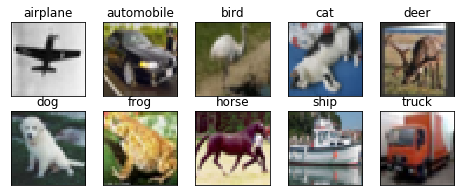

In [48]:
num_test, _, _, _ =  x_train.shape
num_classes = len(np.unique(y_train))
num_train, img_channels, img_rows, img_cols =  x_train.shape
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = (x_train[idx,::]*255.0).astype('uint8')
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))
    ax.set_title(class_names[i])
    plt.imshow(im[:,:,:])
plt.show()

In [49]:
N_CHANNELS = 3

In [50]:
EMOJI_SHAPE = (32, 32, 3)

In [55]:
'''#OG
EMBEDDING_SIZE = 100
FILTER_SIZE = 20
BATCH_SIZE = 16

changing just emb_size to 10 seemed to do something good
'''

EMBEDDING_SIZE = 10
FILTER_SIZE = 30
BATCH_SIZE = 16

In [56]:
class VariationalLayer(KerasLayer):

    def __init__(self, embedding_dim= int, epsilon_std=1.):
        '''A custom "variational" Keras layer that completes the
        variational autoencoder.

        Args:
            embedding_dim : The desired number of latent dimensions in our
                embedding space.
        '''
        self.embedding_dim = embedding_dim
        self.epsilon_std = epsilon_std
        super(VariationalLayer, self).__init__()

    def build(self, input_shape):
        self.z_mean_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_mean_weights'
        )
        self.z_mean_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_mean_bias'
        )
        self.z_log_var_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_log_var_weights'
        )
        self.z_log_var_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_log_var_bias'
        )
        super(VariationalLayer, self).build(input_shape)

    def call(self, x):
        z_mean = K.dot(x, self.z_mean_weights) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_weights) + self.z_log_var_bias
        epsilon = K.random_normal(
            shape=K.shape(z_log_var),
            mean=0.,
            stddev=self.epsilon_std
        )

        kl_loss_numerator = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_loss_numerator, axis=-1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def loss(self, x, x_decoded):
        base_loss = binary_crossentropy(x, x_decoded) 
        base_loss = tf.reduce_sum(base_loss, axis=[-1, -2])
        return base_loss + self.kl_loss

    def compute_output_shape(self, input_shape):
        return input_shape[:1] + (self.embedding_dim,)

In [57]:
# encoder
original = Input(shape=EMOJI_SHAPE, name='original')
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, input_shape=original.shape, padding='same', activation='relu')(original)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)

flat = Flatten()(conv)
variational_layer = VariationalLayer(EMBEDDING_SIZE)
variational_params = variational_layer(flat)

encoder = Model([original], [variational_params], name='encoder')

# decoder
encoded = Input(shape=(EMBEDDING_SIZE,))

upsample = Dense(np.multiply.reduce(EMOJI_SHAPE), activation='relu')(encoded)
reshape = Reshape(EMOJI_SHAPE)(upsample)

deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu', input_shape=encoded.shape)(reshape)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
dropout = Dropout(0.01)(deconv)
reconstructed = Conv2DTranspose(filters=N_CHANNELS, kernel_size=3, padding='same', activation='sigmoid')(dropout)

decoder = Model([encoded], [reconstructed], name='decoder')

# end-to-end
encoder_decoder = Model([original], decoder(encoder([original])))

In [58]:
encoder_decoder.compile(optimizer=Adam(.005), loss=variational_layer.loss)

WEIGHTS_PATH = 'weights/epoch_{epoch:02d}-loss_{val_loss:.2f}.hdf5'
checkpoint_callback = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

encoder_decoder_fit = encoder_decoder.fit(
    x=x_train,
    y=x_train,
    batch_size=30,
    epochs=20,
    validation_data=(x_test, x_test),
    callbacks=[checkpoint_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
24570/50000 [=============>................] - ETA: 39s - loss: 711.7912

KeyboardInterrupt: 

In [37]:
%%bash 
pwd

/home/cocjinjb/cs375/2017/assignment2


In [38]:
prediction = encoder_decoder.predict(x_test)

In [39]:
test_show = (x_test.transpose([1,2,3,0])*255.0).astype('uint8')
pred_test_show = (prediction.transpose([1,2,3,0])*255.0).astype('uint8')

In [40]:
print(test_show.shape)
print(pred_test_show.shape)

(32, 32, 3, 10000)
(32, 32, 3, 10000)


In [41]:
def show_row(in_row, num_show = None):
    from matplotlib.pyplot import figure, imshow, axis
    from matplotlib.image import imread
    
    if num_show is None:
        num_show = len(in_row)
    fig = figure(figsize = [20, 6])
    for i in range(num_show):
        a = fig.add_subplot(1,num_show, i+1)
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        imshow(in_row[:,:,:,i])

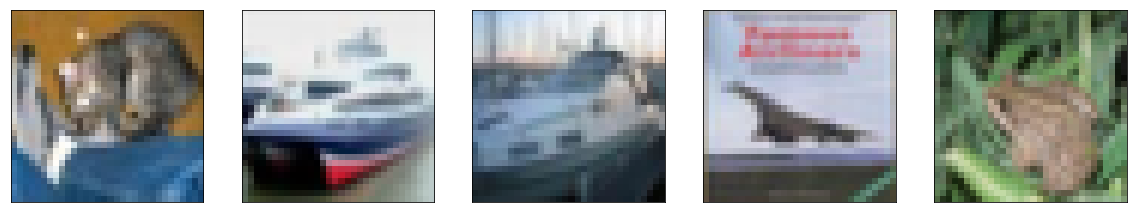

In [42]:
show_row(test_show, 5)

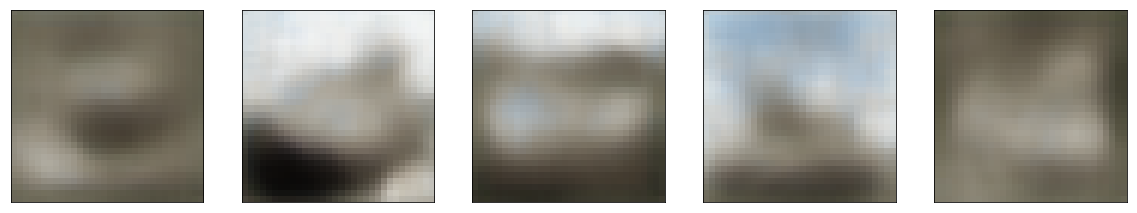

In [43]:
show_row(pred_test_show, 5)